# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [13]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])   
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)  
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)


/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/1780927228.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/1780927228.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat 

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [14]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [15]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [16]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [28]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/1098455523.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [30]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)

# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/1145192065.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/1145192065.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [31]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/3211748656.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_9451/3211748656.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [32]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [39]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.330172
Epoch 1, loss: 2.324864
Epoch 2, loss: 2.321661
Epoch 3, loss: 2.319486
Epoch 4, loss: 2.315051
Epoch 5, loss: 2.312794
Epoch 6, loss: 2.311997
Epoch 7, loss: 2.311030
Epoch 8, loss: 2.307720
Epoch 9, loss: 2.307321


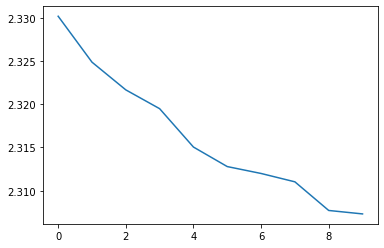

In [41]:
# let's look at the loss history!
plt.plot(loss_history)

In [45]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.171
Epoch 0, loss: 2.293504
Epoch 1, loss: 2.294481
Epoch 2, loss: 2.292677
Epoch 3, loss: 2.293434
Epoch 4, loss: 2.292737
Epoch 5, loss: 2.295767
Epoch 6, loss: 2.291686
Epoch 7, loss: 2.294721
Epoch 8, loss: 2.293940
Epoch 9, loss: 2.292684
Epoch 10, loss: 2.294951
Epoch 11, loss: 2.292133
Epoch 12, loss: 2.294112
Epoch 13, loss: 2.297670
Epoch 14, loss: 2.296757
Epoch 15, loss: 2.293543
Epoch 16, loss: 2.293842
Epoch 17, loss: 2.298310
Epoch 18, loss: 2.295565
Epoch 19, loss: 2.290984
Epoch 20, loss: 2.298251
Epoch 21, loss: 2.296783
Epoch 22, loss: 2.292371
Epoch 23, loss: 2.295656
Epoch 24, loss: 2.296400
Epoch 25, loss: 2.295967
Epoch 26, loss: 2.298829
Epoch 27, loss: 2.293550
Epoch 28, loss: 2.292130
Epoch 29, loss: 2.293090
Epoch 30, loss: 2.295027
Epoch 31, loss: 2.297270
Epoch 32, loss: 2.300594
Epoch 33, loss: 2.297313
Epoch 34, loss: 2.297115
Epoch 35, loss: 2.292840
Epoch 36, loss: 2.293308
Epoch 37, loss: 2.292161
Epoch 38, loss: 2.299124
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [61]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5] 
reg_strengths = [1e-4, 1e-5, 1e-6] 

best_classifier = None
best_val_accuracy = 0


for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, batch_size, lr, rs, num_epochs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_val_accuracy < accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
            

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.300408
Epoch 1, loss: 2.300929
Epoch 2, loss: 2.301147
Epoch 3, loss: 2.299314
Epoch 4, loss: 2.297430
Epoch 5, loss: 2.297710
Epoch 6, loss: 2.300063
Epoch 7, loss: 2.293306
Epoch 8, loss: 2.293689
Epoch 9, loss: 2.296143
Epoch 10, loss: 2.292259
Epoch 11, loss: 2.293148
Epoch 12, loss: 2.291685
Epoch 13, loss: 2.289433
Epoch 14, loss: 2.293681
Epoch 15, loss: 2.289214
Epoch 16, loss: 2.285024
Epoch 17, loss: 2.286956
Epoch 18, loss: 2.291519
Epoch 19, loss: 2.295362
Epoch 20, loss: 2.282206
Epoch 21, loss: 2.288724
Epoch 22, loss: 2.289236
Epoch 23, loss: 2.285455
Epoch 24, loss: 2.283105
Epoch 25, loss: 2.279143
Epoch 26, loss: 2.283452
Epoch 27, loss: 2.283222
Epoch 28, loss: 2.284938
Epoch 29, loss: 2.276974
Epoch 30, loss: 2.283940
Epoch 31, loss: 2.278264
Epoch 32, loss: 2.268812
Epoch 33, loss: 2.280884
Epoch 34, loss: 2.271438
Epoch 35, loss: 2.274798
Epoch 36, loss: 2.266283
Epoch 37, loss: 2.271401
Epoch 38, loss: 2.273089
Epoch 39, loss: 2.269406
Epoch 40, 

Epoch 126, loss: 2.216537
Epoch 127, loss: 2.213265
Epoch 128, loss: 2.216566
Epoch 129, loss: 2.195551
Epoch 130, loss: 2.247987
Epoch 131, loss: 2.215070
Epoch 132, loss: 2.233293
Epoch 133, loss: 2.208474
Epoch 134, loss: 2.218856
Epoch 135, loss: 2.232945
Epoch 136, loss: 2.224680
Epoch 137, loss: 2.214830
Epoch 138, loss: 2.204754
Epoch 139, loss: 2.208081
Epoch 140, loss: 2.229585
Epoch 141, loss: 2.218196
Epoch 142, loss: 2.207449
Epoch 143, loss: 2.207832
Epoch 144, loss: 2.220846
Epoch 145, loss: 2.218441
Epoch 146, loss: 2.232677
Epoch 147, loss: 2.215297
Epoch 148, loss: 2.227589
Epoch 149, loss: 2.203196
Epoch 150, loss: 2.217012
Epoch 151, loss: 2.235460
Epoch 152, loss: 2.205487
Epoch 153, loss: 2.207417
Epoch 154, loss: 2.234079
Epoch 155, loss: 2.211488
Epoch 156, loss: 2.192524
Epoch 157, loss: 2.243479
Epoch 158, loss: 2.223765
Epoch 159, loss: 2.216923
Epoch 160, loss: 2.185164
Epoch 161, loss: 2.216274
Epoch 162, loss: 2.231226
Epoch 163, loss: 2.204963
Epoch 164, l

Epoch 50, loss: 2.296497
Epoch 51, loss: 2.294907
Epoch 52, loss: 2.297444
Epoch 53, loss: 2.299234
Epoch 54, loss: 2.298169
Epoch 55, loss: 2.295252
Epoch 56, loss: 2.296446
Epoch 57, loss: 2.297542
Epoch 58, loss: 2.295933
Epoch 59, loss: 2.298568
Epoch 60, loss: 2.297882
Epoch 61, loss: 2.298255
Epoch 62, loss: 2.297626
Epoch 63, loss: 2.297452
Epoch 64, loss: 2.295674
Epoch 65, loss: 2.297835
Epoch 66, loss: 2.298674
Epoch 67, loss: 2.299419
Epoch 68, loss: 2.297151
Epoch 69, loss: 2.296469
Epoch 70, loss: 2.295412
Epoch 71, loss: 2.296668
Epoch 72, loss: 2.296296
Epoch 73, loss: 2.292826
Epoch 74, loss: 2.292717
Epoch 75, loss: 2.292630
Epoch 76, loss: 2.296975
Epoch 77, loss: 2.293801
Epoch 78, loss: 2.294960
Epoch 79, loss: 2.296073
Epoch 80, loss: 2.295801
Epoch 81, loss: 2.293269
Epoch 82, loss: 2.295095
Epoch 83, loss: 2.296121
Epoch 84, loss: 2.293091
Epoch 85, loss: 2.293984
Epoch 86, loss: 2.296581
Epoch 87, loss: 2.290769
Epoch 88, loss: 2.291943
Epoch 89, loss: 2.297286


Epoch 172, loss: 2.294350
Epoch 173, loss: 2.284442
Epoch 174, loss: 2.289677
Epoch 175, loss: 2.286897
Epoch 176, loss: 2.291045
Epoch 177, loss: 2.285322
Epoch 178, loss: 2.286536
Epoch 179, loss: 2.283758
Epoch 180, loss: 2.284789
Epoch 181, loss: 2.285522
Epoch 182, loss: 2.282855
Epoch 183, loss: 2.286171
Epoch 184, loss: 2.288594
Epoch 185, loss: 2.284811
Epoch 186, loss: 2.288736
Epoch 187, loss: 2.281424
Epoch 188, loss: 2.288831
Epoch 189, loss: 2.288126
Epoch 190, loss: 2.289444
Epoch 191, loss: 2.290647
Epoch 192, loss: 2.286166
Epoch 193, loss: 2.290042
Epoch 194, loss: 2.283250
Epoch 195, loss: 2.285556
Epoch 196, loss: 2.282813
Epoch 197, loss: 2.287253
Epoch 198, loss: 2.283727
Epoch 199, loss: 2.282269
Epoch 0, loss: 2.302288
Epoch 1, loss: 2.302398
Epoch 2, loss: 2.302830
Epoch 3, loss: 2.301716
Epoch 4, loss: 2.302600
Epoch 5, loss: 2.301255
Epoch 6, loss: 2.302376
Epoch 7, loss: 2.301897
Epoch 8, loss: 2.301072
Epoch 9, loss: 2.301088
Epoch 10, loss: 2.302569
Epoch 1

Epoch 97, loss: 2.301647
Epoch 98, loss: 2.302184
Epoch 99, loss: 2.301509
Epoch 100, loss: 2.301243
Epoch 101, loss: 2.301187
Epoch 102, loss: 2.301478
Epoch 103, loss: 2.302114
Epoch 104, loss: 2.302338
Epoch 105, loss: 2.300661
Epoch 106, loss: 2.300597
Epoch 107, loss: 2.301840
Epoch 108, loss: 2.301675
Epoch 109, loss: 2.301221
Epoch 110, loss: 2.300464
Epoch 111, loss: 2.301324
Epoch 112, loss: 2.300783
Epoch 113, loss: 2.301921
Epoch 114, loss: 2.301991
Epoch 115, loss: 2.302816
Epoch 116, loss: 2.301424
Epoch 117, loss: 2.301771
Epoch 118, loss: 2.300661
Epoch 119, loss: 2.303141
Epoch 120, loss: 2.301493
Epoch 121, loss: 2.301709
Epoch 122, loss: 2.302727
Epoch 123, loss: 2.301785
Epoch 124, loss: 2.301192
Epoch 125, loss: 2.300859
Epoch 126, loss: 2.300600
Epoch 127, loss: 2.301239
Epoch 128, loss: 2.301910
Epoch 129, loss: 2.301644
Epoch 130, loss: 2.301560
Epoch 131, loss: 2.300246
Epoch 132, loss: 2.300852
Epoch 133, loss: 2.301320
Epoch 134, loss: 2.301561
Epoch 135, loss

Epoch 19, loss: 2.301641
Epoch 20, loss: 2.303168
Epoch 21, loss: 2.302908
Epoch 22, loss: 2.303191
Epoch 23, loss: 2.302904
Epoch 24, loss: 2.303844
Epoch 25, loss: 2.302029
Epoch 26, loss: 2.302924
Epoch 27, loss: 2.303878
Epoch 28, loss: 2.302186
Epoch 29, loss: 2.302904
Epoch 30, loss: 2.302250
Epoch 31, loss: 2.301264
Epoch 32, loss: 2.302402
Epoch 33, loss: 2.302085
Epoch 34, loss: 2.302960
Epoch 35, loss: 2.302274
Epoch 36, loss: 2.302735
Epoch 37, loss: 2.302862
Epoch 38, loss: 2.302045
Epoch 39, loss: 2.302697
Epoch 40, loss: 2.303019
Epoch 41, loss: 2.301694
Epoch 42, loss: 2.303447
Epoch 43, loss: 2.302126
Epoch 44, loss: 2.302884
Epoch 45, loss: 2.302660
Epoch 46, loss: 2.302941
Epoch 47, loss: 2.301766
Epoch 48, loss: 2.301485
Epoch 49, loss: 2.302113
Epoch 50, loss: 2.302927
Epoch 51, loss: 2.301555
Epoch 52, loss: 2.302221
Epoch 53, loss: 2.302080
Epoch 54, loss: 2.302309
Epoch 55, loss: 2.302961
Epoch 56, loss: 2.301088
Epoch 57, loss: 2.301894
Epoch 58, loss: 2.302020


# Какой же точности мы добились на тестовых данных?

In [62]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.192000
